# EDA for EIA Data and using LightGBM

## Load in libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import pickle
import re

In [39]:
demand_df = pd.read_parquet('../data/energy_demand.parquet')
weather_df = pd.read_parquet('../data/weather.parquet')
XLE_df = pd.read_csv('../data/XLE.csv')
holidays = pd.read_csv('../data/holiday.csv')

In [40]:
demand_df['respondent-name'] = demand_df['respondent-name'].replace('Florida', 'Florida Power and Light')

In [41]:
demand_df['period'] = pd.to_datetime(demand_df.period)

# Cleaning and Mergin DataFrames
We create a column called 'name' which is a duplicate of respondent-name and then replace the names with the city names. We will us the
name column to merge our weather data which has the city names.

In [42]:
demand_df['name'] = demand_df['respondent-name']
demand_df['name'].value_counts()

name
California Independent System Operator         68872
New York Independent System Operator           68866
Florida Power and Light                        68862
Electric Reliability Council of Texas, Inc.    68817
Name: count, dtype: int64

In [43]:
respondents =['Electric Reliability Council of Texas, Inc.' ,
              'New York Independent System Operator',
              'Florida Power and Light' ,
               'California Independent System Operator',]

In [44]:
demand_df['name'] = demand_df['name'].replace(respondents[3], 'Los Angeles')
demand_df['name'] = demand_df['name'].replace(respondents[2], 'Tampa')
demand_df['name'] = demand_df['name'].replace(respondents[0], 'Austin')
demand_df['name'] = demand_df['name'].replace(respondents[1], 'new york city')

In [45]:
energy_df = pd.merge(demand_df, weather_df, how='inner', on=['name', 'period'], suffixes=('', '2'))

## Merging XLE
XLE is a index fund that tracks the energy sector. We will use this data to represent the state of enery prices. The data was source
from [yahoo finance](https://finance.yahoo.com/quote/XLE?p=XLE&.tsrc=fin-srch). We used the adjusted close which is the closing price
at 4pm est adjust for dividends and share splits.

Since the data is daily we will join on the year and day of year. We will also create a 30 day and 60 day lag period. We believe this
will be helpful to the model because not everyone adjusts their energy consumption immediately and the lags could add to the model
performance.


In [46]:
XLE_df = XLE_df.set_index('Date')
XLE_df.index = pd.to_datetime(XLE_df.index)
XLE_df = XLE_df[['Adj Close']].copy()
XLE_df['year'] = XLE_df.index.year
XLE_df['dayofyear'] = XLE_df.index.dayofyear

In [47]:
XLE_df.sort_index(inplace=True)

In [48]:
XLE_df['Adj_Close_30D_lag'] = XLE_df['Adj Close'].shift(freq='28D')
XLE_df['Adj_Close_60D_lag'] = XLE_df['Adj Close'].shift(freq='56D')
energy_df = pd.merge(energy_df,XLE_df,how='left', on=['year','dayofyear'])

## Merging Holidays

We merge holdiays on year and day of year.

In [49]:
holidays =holidays.drop('Date',axis=1)
energy_df = pd.merge(energy_df,holidays, how='left', on=['year','dayofyear'])

## Check for nulls
We have some nulls in the dataframe. Since this is time series data we will use a backfill to fill null values.
Backfilling helps us keep more data and also smoothes out the data beacuse we will have less gaps in time.

Backfilling makes sense here because we are using weather data. If the temperature yesterday was 70 degrees
then it is most likly the following day will be 70 degrees or close to it.

In [50]:
energy_df.isna().sum();

In [51]:
energy_df['value'] = energy_df['value'].bfill()
energy_df['solarradiation'] = energy_df['solarradiation'].bfill()
energy_df['uvindex'] = energy_df['uvindex'].bfill()
energy_df['snow'] = energy_df['snow'].bfill()
energy_df['Adj Close'] = energy_df['Adj Close'].bfill()
energy_df['Adj_Close_30D_lag'] = energy_df['Adj_Close_30D_lag'].ffill()
energy_df['Adj_Close_60D_lag'] = energy_df['Adj_Close_60D_lag'].ffill()

## Set the index to period and conver to a datetime

In [52]:
energy_df = energy_df.set_index('period')
energy_df.index = pd.to_datetime(energy_df.index)

## Create a weekend feature

In [53]:
energy_df["Is Weekend"] = energy_df.index.day_name().isin(['Saturday', 'Sunday'])

In [54]:
energy_df.columns;

In [55]:
columns = ['respondent-name','value',
        'year', 'month', 'days', 'hour', 'quarter', 'dayofyear',
        'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'uvindex', 'conditions',
       'icon','Adj Close', 'Adj_Close_30D_lag', 'Adj_Close_60D_lag', 'Holiday','Is Weekend']

In [56]:
energy_df = energy_df[columns].copy()

## Drop redundant columns

In [57]:
energy_df = energy_df.drop(['conditions','icon'], axis=1)

## Create dummy variables

In [58]:
energy_df.rename(columns={'respondent-name':'respondent',}, inplace=True)
energy_df = pd.get_dummies(energy_df, columns=['Holiday','Is Weekend'], drop_first=True, dtype=float)

## Fixing column names
LGBM will throw an error if there are any special characters in the column names. The follwing code will
remove those characters and rename the columns

In [59]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in energy_df.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
energy_df = energy_df.rename(columns=new_names)

## Checking Outliers

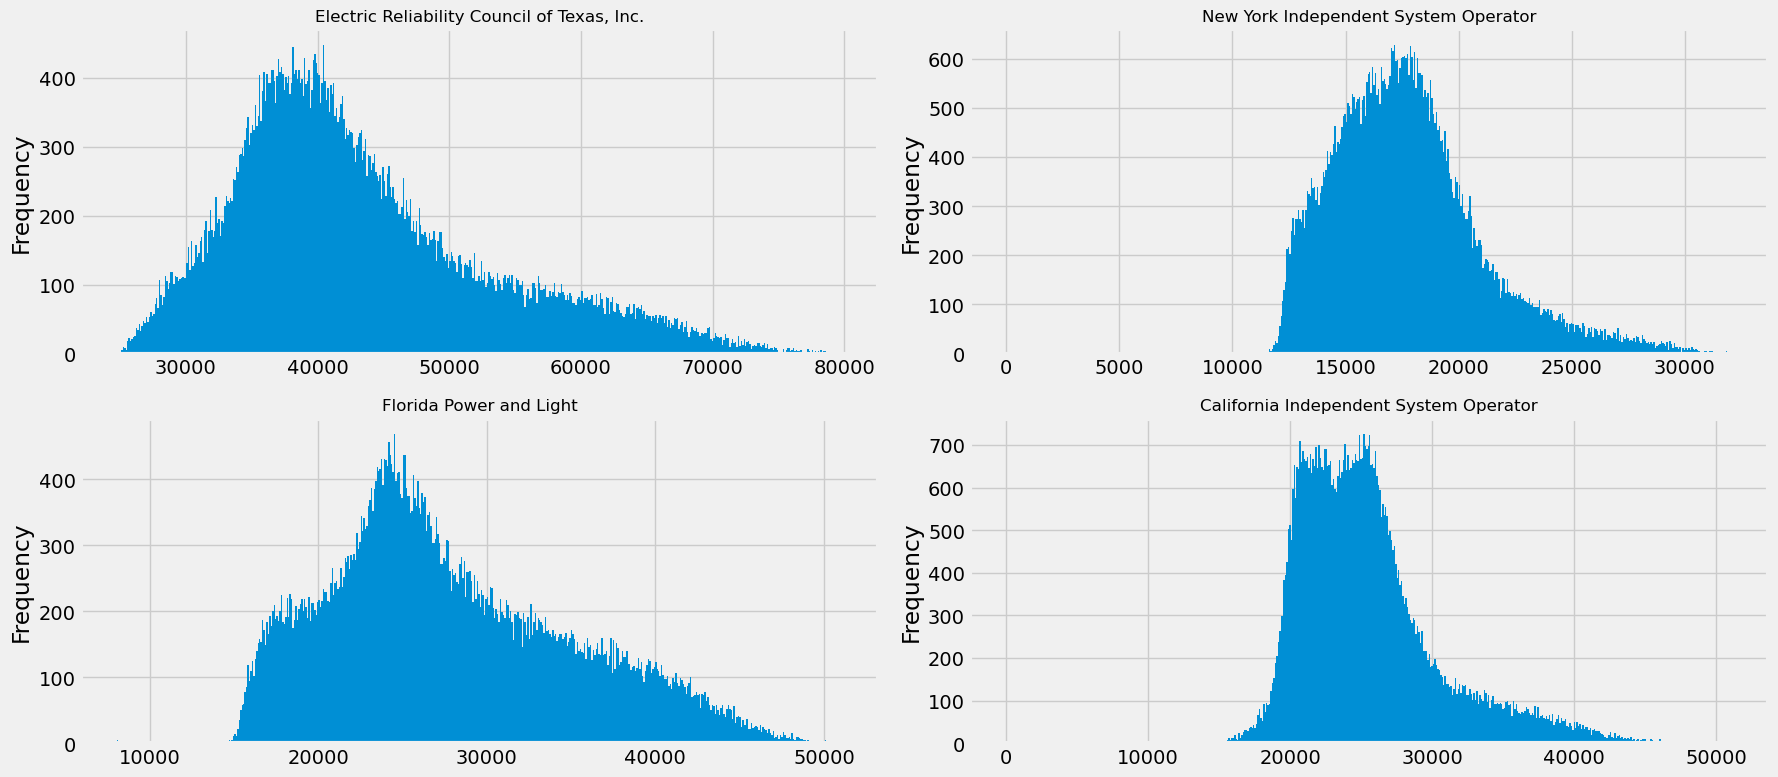

In [60]:
for n,res in enumerate(respondents):
    ax = plt.subplot(2,2,n+1)
    energy_df.query(f"respondent == '{res}' ")['value'].plot(kind='hist', bins =500,ax =ax, figsize=(18,8))
    ax.set_title(label =f'{res}',fontsize =12)
    plt.tight_layout()

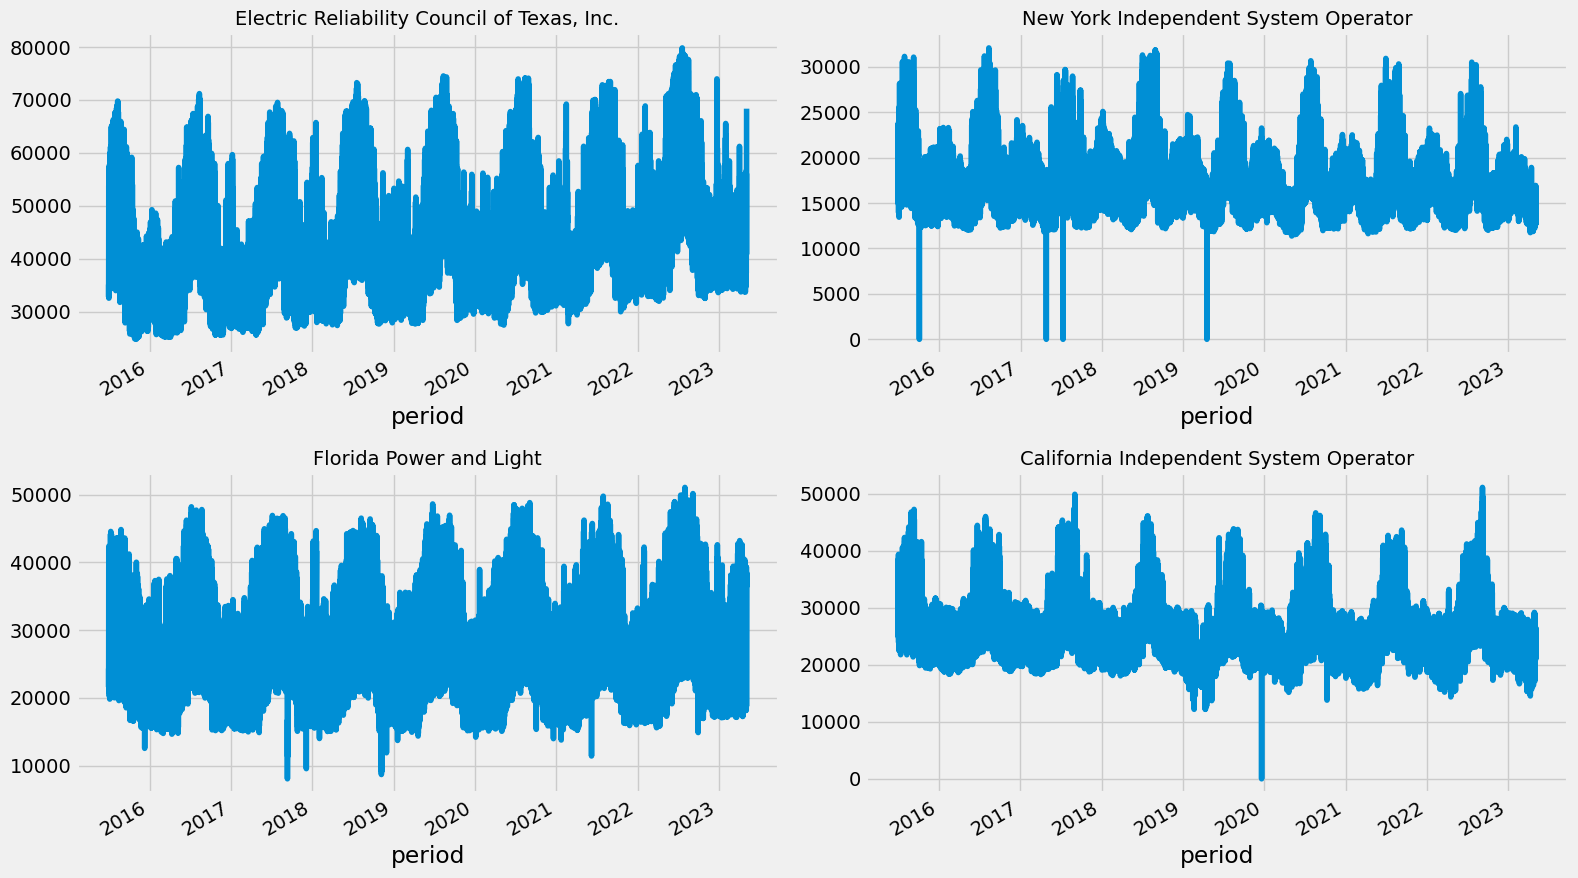

In [61]:
for n,res in enumerate(respondents):
    ax = plt.subplot(2,2,n+1)
    energy_df.query(f"respondent == '{res}' ")['value'].plot(ax =ax, figsize=(16,9))
    ax.set_title(label =f'{res}',fontsize =14)
    plt.tight_layout()

## Filter Outliers
We have identified the outliers in our plot and filtering our data. We also seperate our States in preperation
for a ml model. After the States are seperated we add 2 more features.
The first line below will create another lag that looks at the demand 72 hours prior. The second line will
create a forecasted feature were we are lookin at the temperature tomorrow.
```
NY['demand_3d_lag'] = NY['value'].shift(72)
NY['24_hours_ahead'] = NY['temp'].shift(-24)
```

In [62]:
NY = energy_df.query("respondent== 'New York Independent System Operator' and value > 11000 and value <32000").copy()
FL = energy_df.query("respondent == 'Florida Power and Light' and value >14000 and value < 49000").copy()
CA = energy_df.query("respondent ==  'California Independent System Operator' and value >15000 and value <46000").copy()
TX = energy_df.query("respondent ==  'Electric Reliability Council of Texas, Inc.' and value <75000 ").copy()

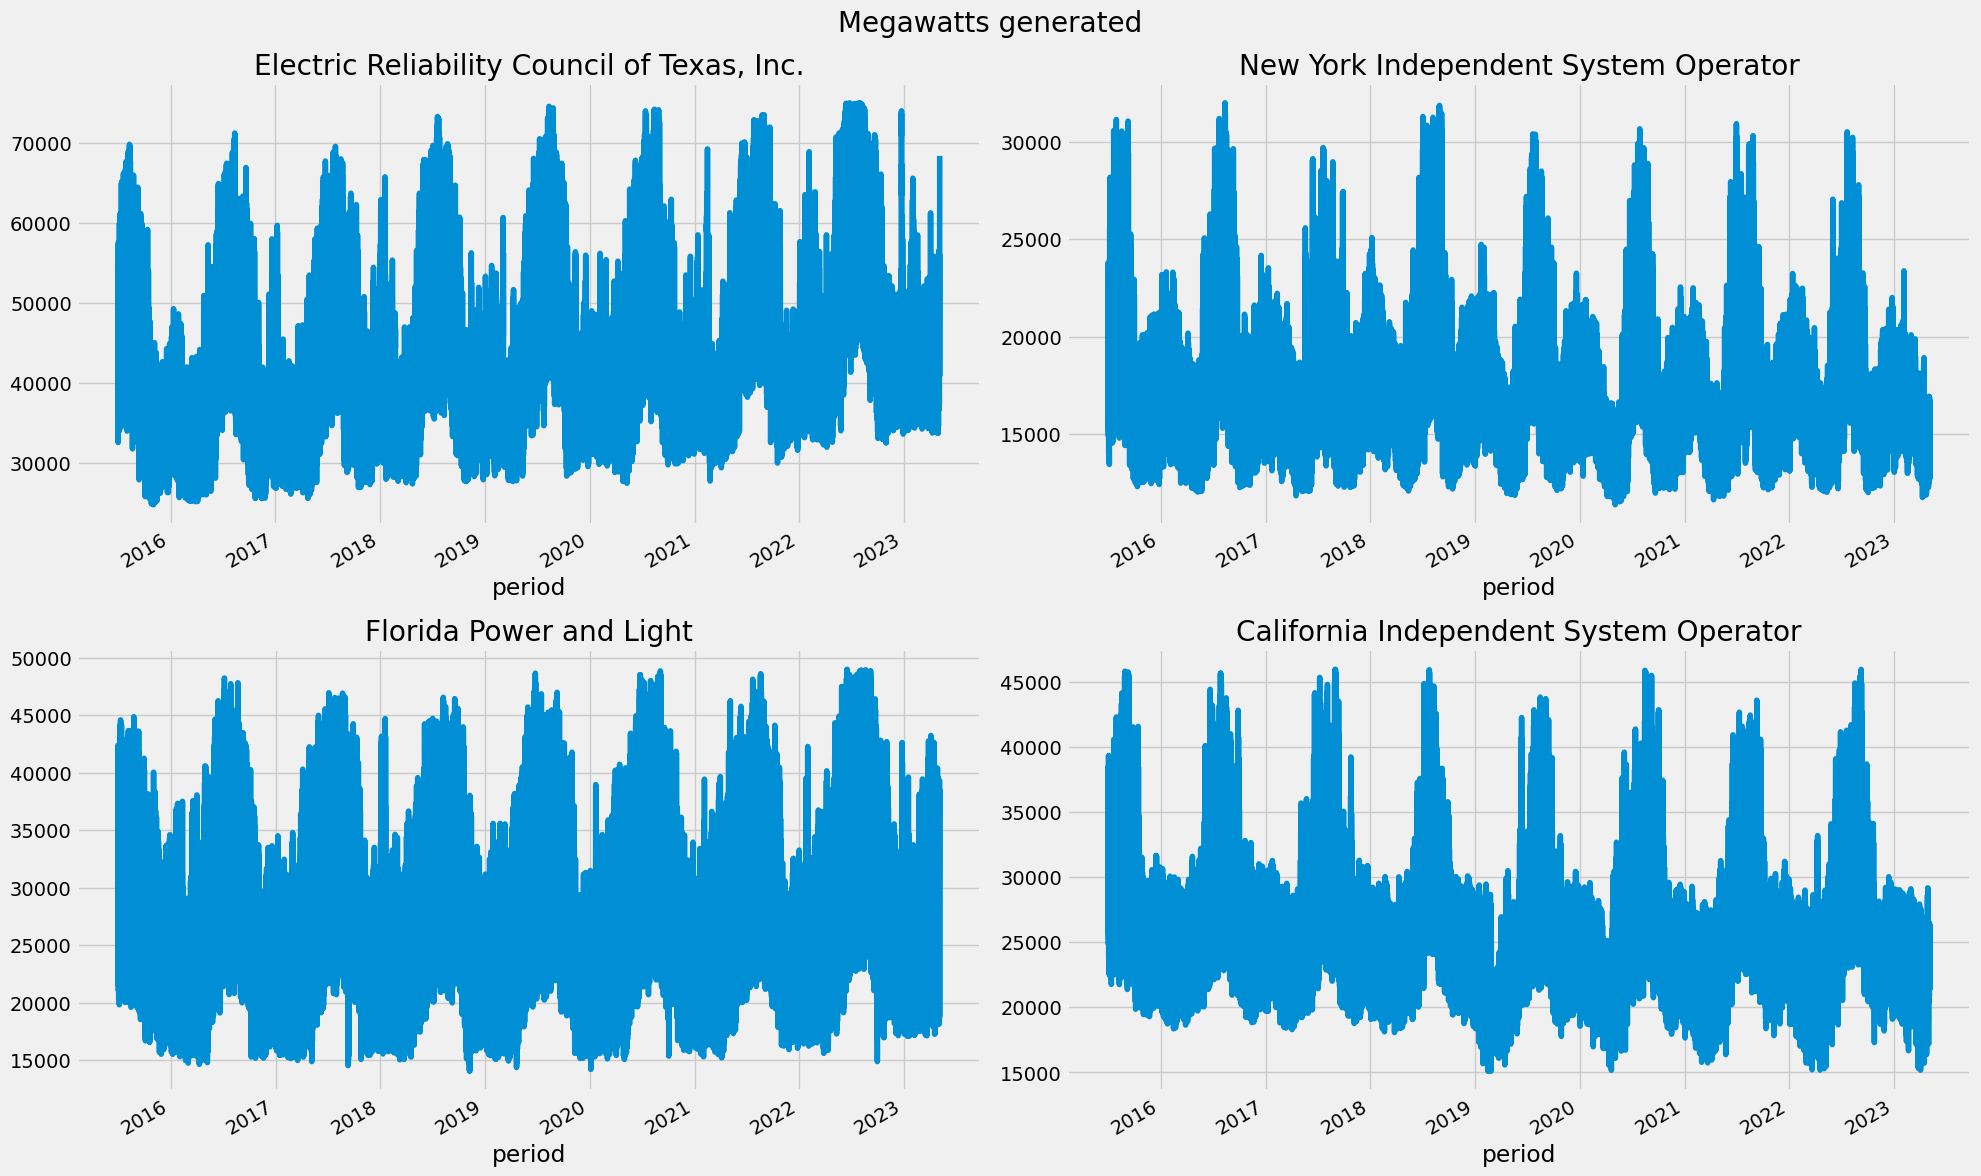

In [63]:
fig, ax = plt.subplots(2,2,figsize=(20,12))
TX['value'].plot(ax=ax[0, 0], title =respondents[0])
NY['value'].plot(ax=ax[0, 1], title = respondents[1])
FL['value'].plot(ax=ax[1, 0], title =respondents[2])
CA['value'].plot(ax=ax[1, 1], title =respondents[3])
fig.suptitle("Megawatts generated", fontsize=20)
plt.tight_layout(pad=1)
plt.show()

In [64]:
NY['demand_3d_lag'] = NY['value'].shift(72)
FL['demand_3d_lag'] = FL['value'].shift(72)
CA['demand_3d_lag'] = CA['value'].shift(72)
TX['demand_3d_lag'] = TX['value'].shift(72)

In [65]:
NY['24_hours_ahead'] = NY['temp'].shift(-24)
FL['24_hours_ahead'] = FL['temp'].shift(-24)
CA['24_hours_ahead'] = CA['temp'].shift(-24)
TX['24_hours_ahead'] = TX['temp'].shift(-24)

In [66]:
NY.dropna(inplace=True)
FL.dropna(inplace=True)
CA.dropna(inplace=True)
TX.dropna(inplace=True)

In [67]:
def create_box_plot(frequency= 'month'):
    """ This function graphs demand based on the frequency.
    Frequency default is 'month'. Other options are
    year, hour, dayofweek, quarter and dayofyear"""
    frequency= frequency.lower()
    fig, ax = plt.subplots(2,2 ,figsize=(20,12))
    sns.boxplot(data=TX, x=frequency, y='value', palette='Blues', ax=ax[0, 0], width=.4, linewidth=.8, fliersize=4)
    ax[0,0].set_title(respondents[0])
    sns.boxplot(data=NY, x=frequency, y='value', palette='Blues', ax=ax[0, 1], width=.4, linewidth=.8, fliersize=4)
    ax[0,1].set_title(respondents[1])
    sns.boxplot(data=FL, x=frequency, y='value', palette='Blues', ax=ax[1, 0], width=.4, linewidth=.8, fliersize=4)
    ax[1,0].set_title(respondents[2])
    sns.boxplot(data=CA, x=frequency, y='value', palette='Blues', ax=ax[1, 1], width=.4, linewidth=.8, fliersize=4)
    ax[1,1].set_title(respondents[3])
    plt.tight_layout(pad=2)
    plt.show()

In [68]:
# hour = create_box_plot('hour')
# month = create_box_plot('month')
# quarter = create_box_plot('quarter')

In [69]:
# NY.to_parquet('../data/ML_Data/NY', engine='pyarrow')
# FL.to_parquet('../data/ML_Data/FL', engine='pyarrow')
# CA.to_parquet('../data/ML_Data/CA', engine='pyarrow')
# TX.to_parquet('../data/ML_Data/TX', engine='pyarrow')

## Visualize Cross validation with SKlearn [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
Since our data is a timer series we can't randomly split. To use cross validation we will test on different time periods.

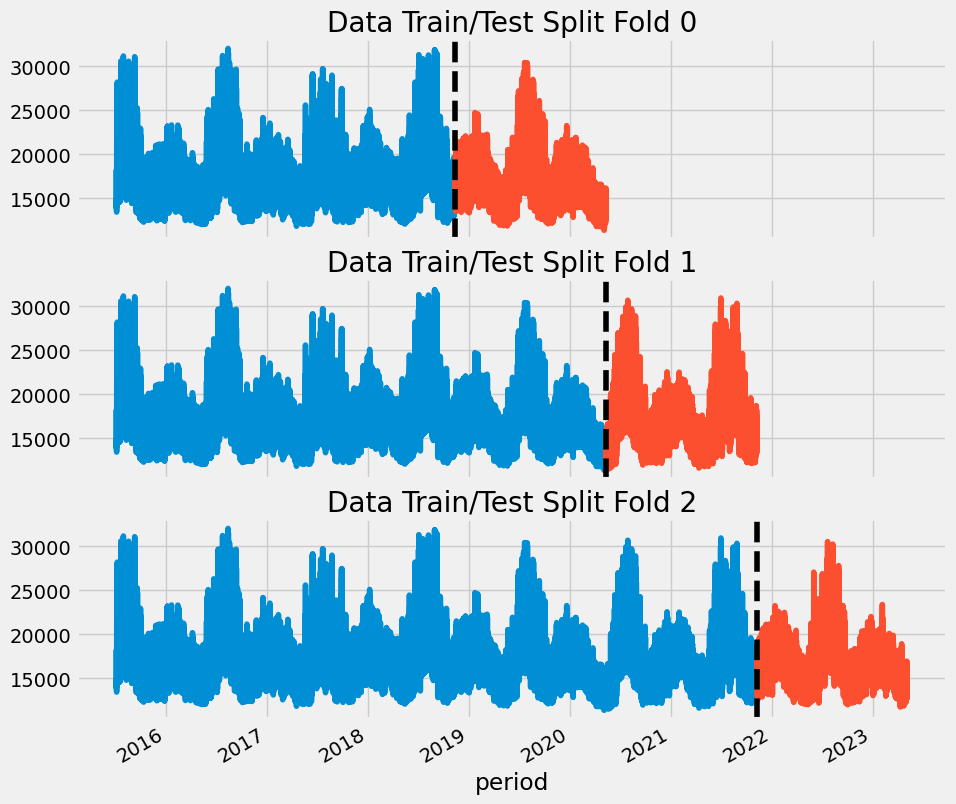

In [70]:
fig, axs = plt.subplots(3,1, figsize=(10,10), sharex=True)
tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
fold = 0
for train_idx, val_idx in tss.split(NY):
    train = NY.iloc[train_idx]
    test = NY.iloc[val_idx]
    train['value'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['value'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [71]:
TARGET = 'value'
FEATURES = NY.columns[2:]

In [72]:
TX_params1 = {
    "n_jobs": -1,
    "boosting": "gbdt",
    "num_iterations": 10000,
    "early_stopping_round": 100,
    "max_depth": 10,
    "learning_rate": 0.005,
    "num_leaves": 30,
    "lambda_l1": 30,
    "lambda_l2": 30,
    "seed": 0,
    "metric": ['rmse','mae'],
    "device_type": 'gpu',
    "min_data_in_leaf": 12,
    "bagging_fraction": .8,
    "cat_smooth": 12,
    'max_bin': 100,
    "bagging_freq": 8,
    "min_sum_hessian_in_leaf" :250,
    'path_smooth':18,
    "feature_fraction": .6,
    "importance_type" :'gain',
    "extra_trees":  False

}

## Traing our model with [LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#)
Since we have to train 4 model we create a function that will take in a dataframe as a parameter. The optional parameters
are params which is a dictionary of parameters to pass to the model. week_list will be used to graph a specfic week of data.
show_graph will defaults to 'no' if yes then the function will plot.
1. the actual vs prediction
2. feature importance
3. a week of data.

The week of data zooms in on our actual and predicted helping us better visualize how the model is performing.

For each cross validation we will store the scores in a list. We have 2 list because we are using rsme and mae
to score our model.

In [75]:
def lgbm_train(df, params=None, week_list=None, show_graph = "no"):
    if params is None:
        params = {}
    tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
    df = df.sort_index()
    fold = 0
    preds = []
    scores_rmse = []
    scores_mae = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]
        reg = LGBMRegressor()
        reg.set_params(**params)
        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0,)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores_rmse.append(score_rmse)
        scores_mae.append(mean_absolute_error(y_test,y_pred))
    print(f'Score across folds {np.mean(scores_rmse):0.4f}')
    print(f'Fold scores:{scores_rmse}')
    print(f'Score across folds {np.mean(scores_mae):0.4f}')
    print(f'Fold scores:{scores_mae}')

    if show_graph.lower() == 'yes':
        if week_list is None:
            week = ['03-20-2022', '03-27-2022']
        else:
            week = week_list
        test['prediction'] = reg.predict(X_test)
        df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
        ax = df[['value']].plot(figsize=(15, 6))
        df['prediction'].plot(ax=ax, style='.')
        plt.legend(['Actual', 'Predicted'],loc='upper right')
        ax.set_title('texas Actual VS. Predicted')
        plt.show()

        ax = df.loc[(df.index > week[0]) & (df.index < week[1])]['value'] \
        .plot(figsize=(15, 6), title='Week Of Data')
        df.loc[(df.index > week[0]) & (df.index < week[1])]['prediction'] \
            .plot()
        plt.legend(['Actual','Predicted'],loc='upper right')
        plt.show()

        fig, ax = plt.subplots(figsize=(10,10))
        fi = pd.DataFrame(data=reg.feature_importances_,
            index = reg.feature_name_,
            columns=['importance'])
        fi.sort_values('importance', ascending=False)[:15].plot(kind='barh', ax=ax)

    return reg, df

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=250, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=250
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored.

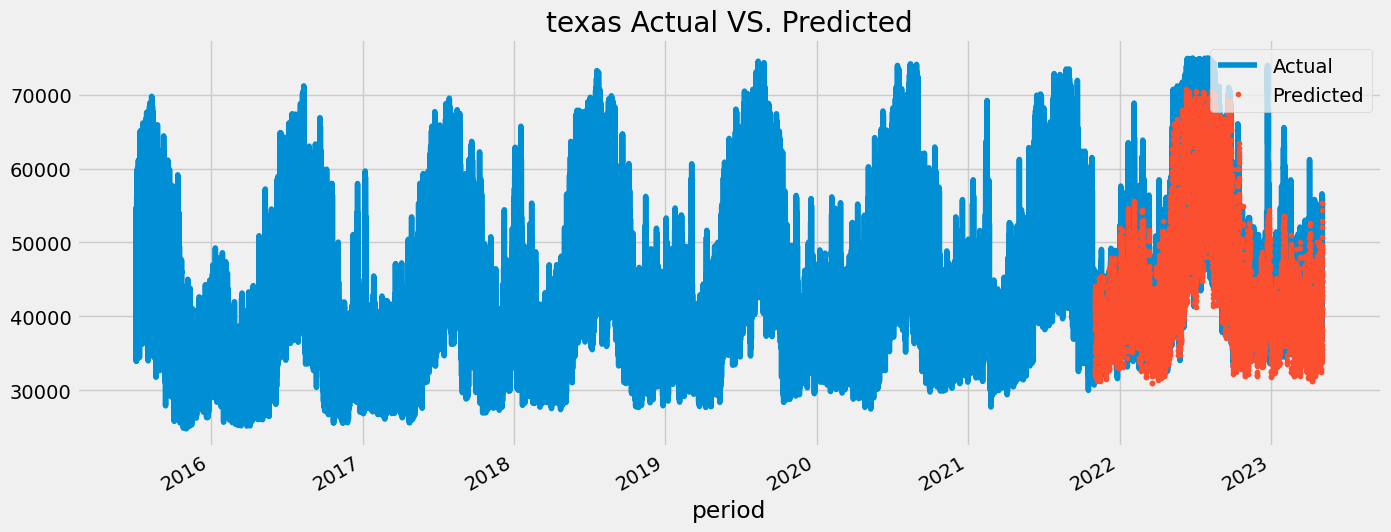

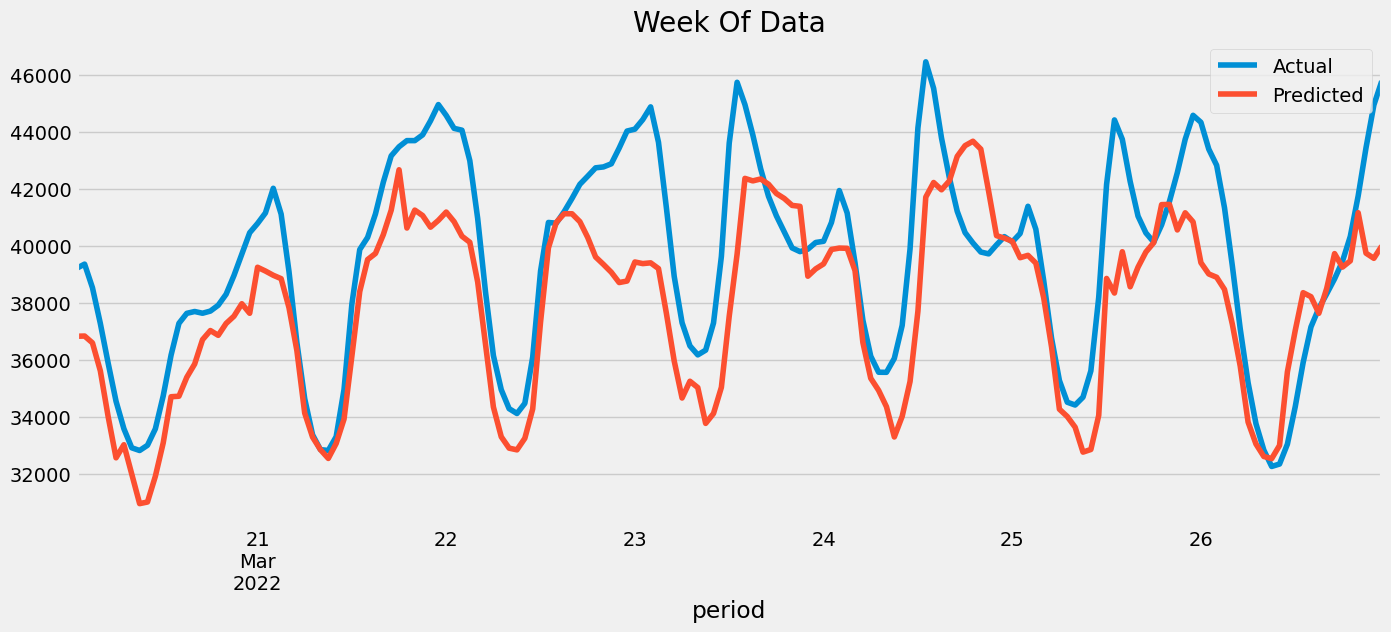

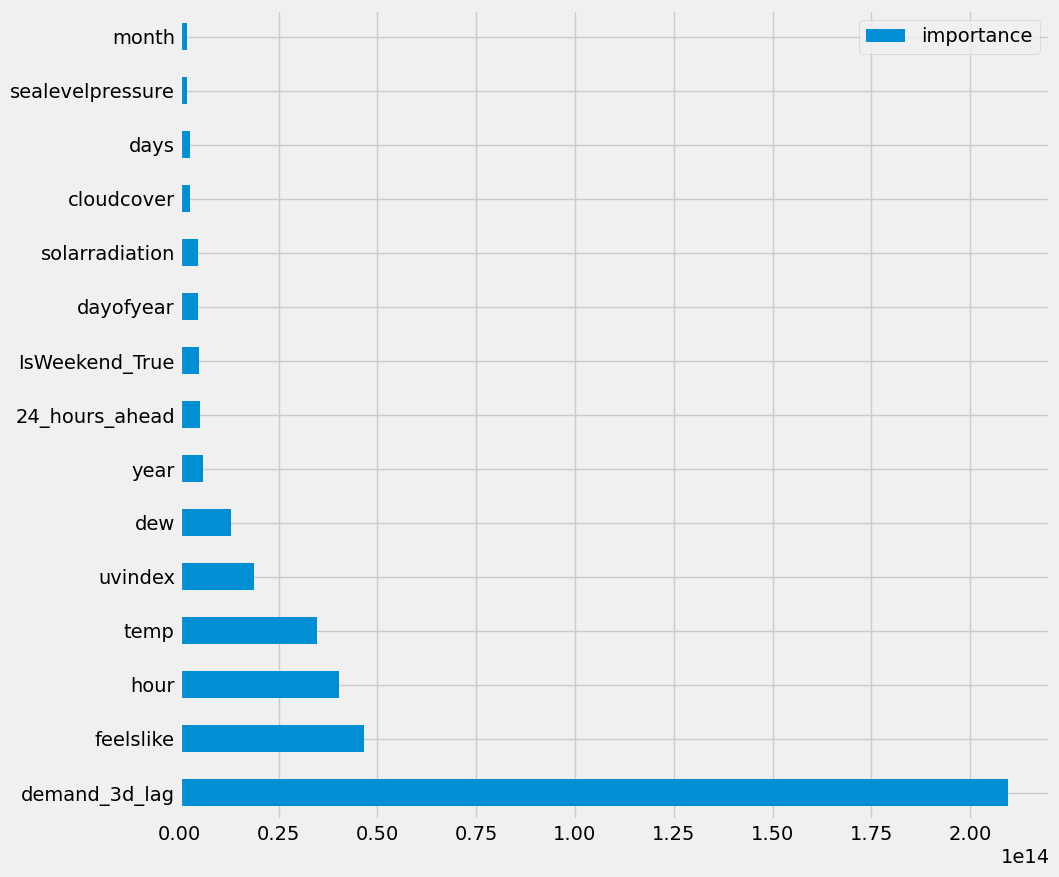

In [76]:
model_TX, Texas_df =lgbm_train(TX, TX_params1, show_graph ='yes') #2700

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=250, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=250
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored.

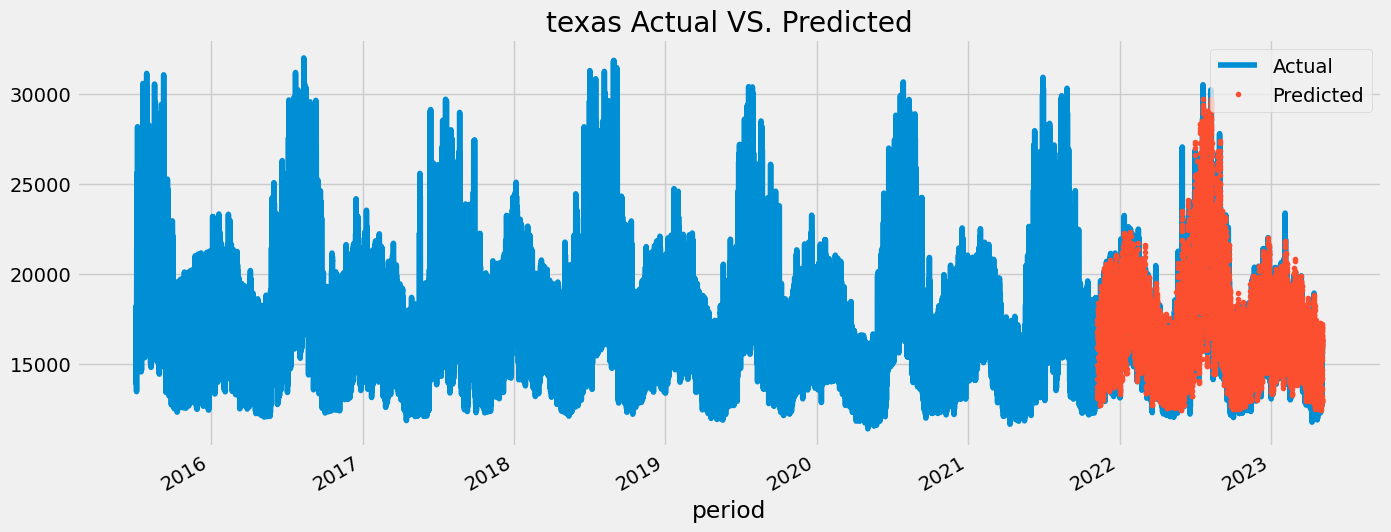

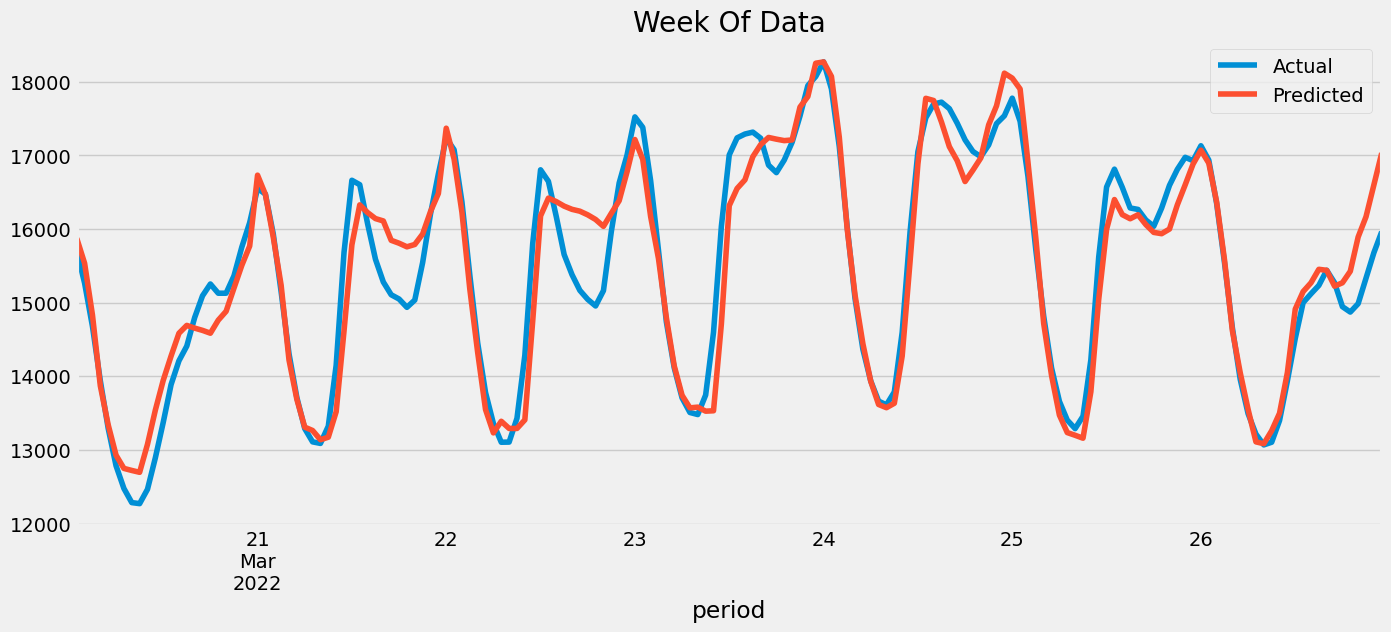

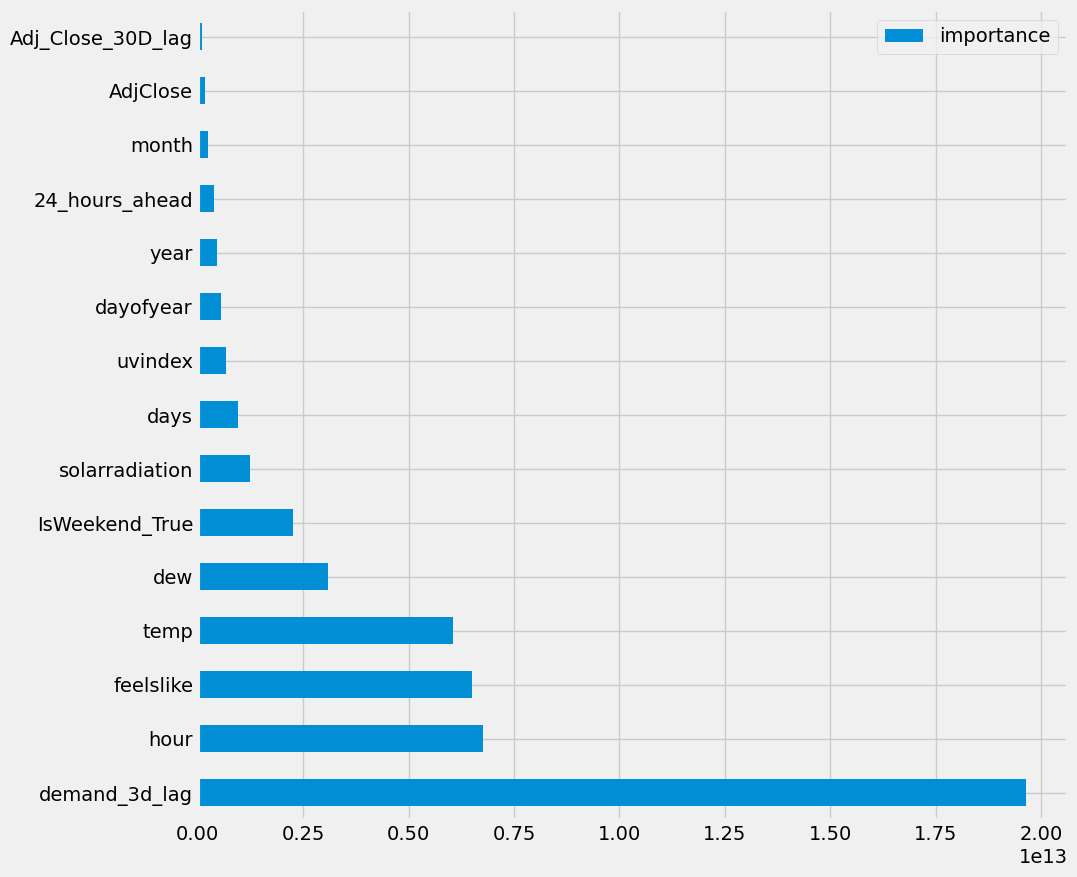

In [77]:
model_NY, NY_df = lgbm_train(NY, TX_params1, show_graph='yes')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=250, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=250
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored.

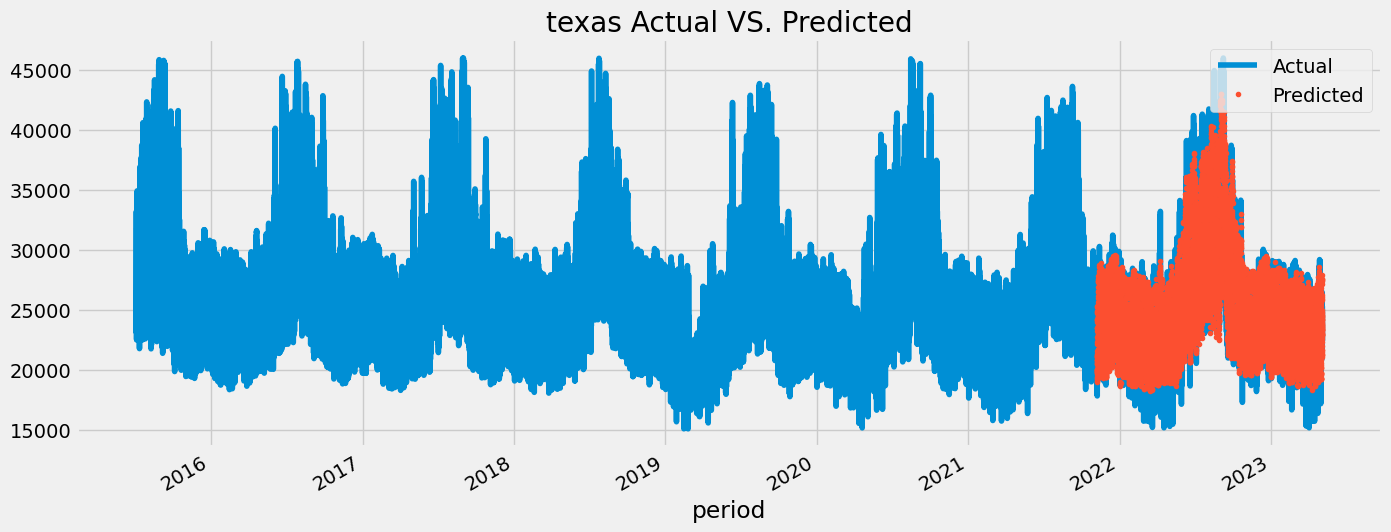

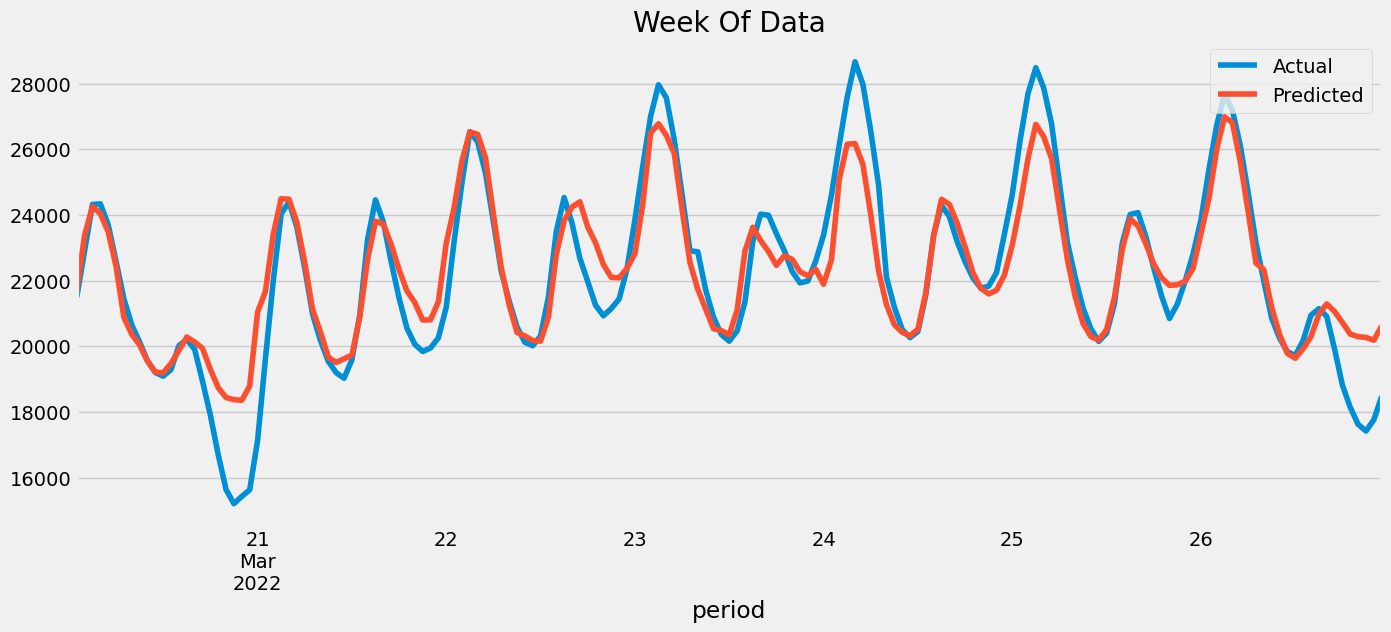

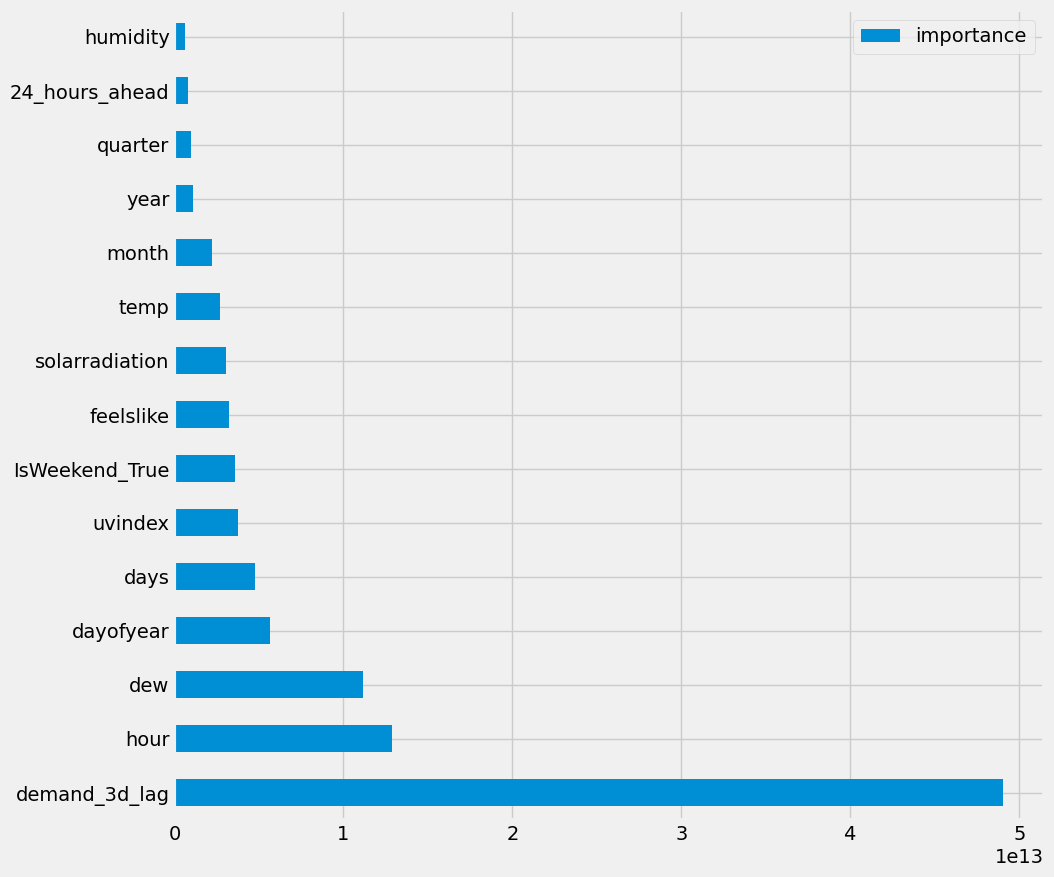

In [78]:
model_CA, CA_df =lgbm_train(CA, TX_params1, show_graph='yes') #1689

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=250, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=250
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored.

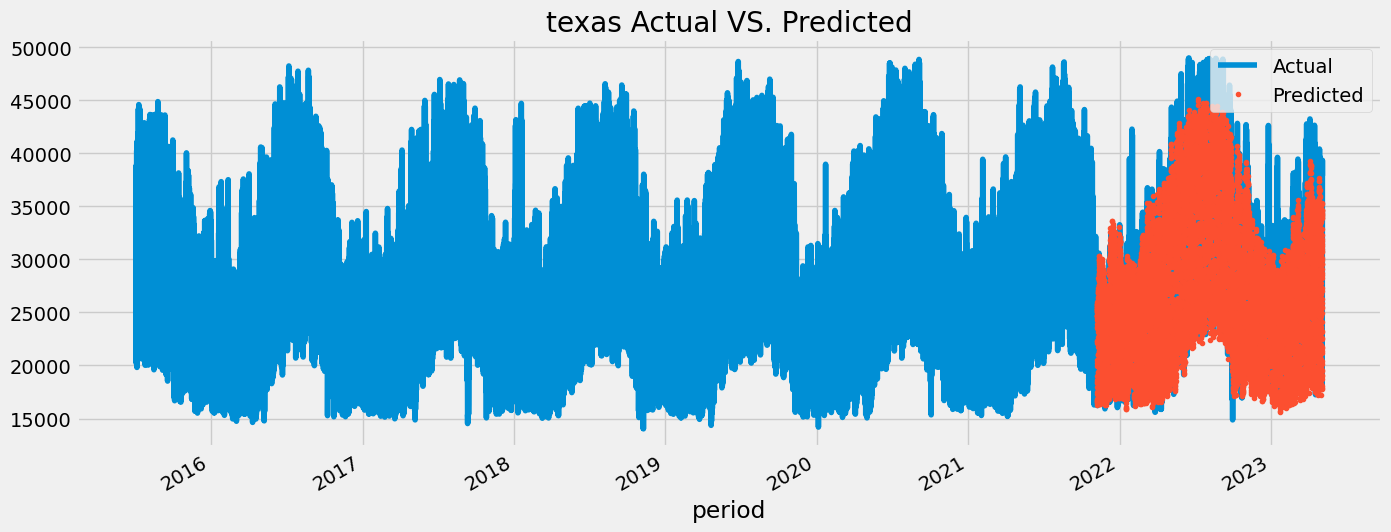

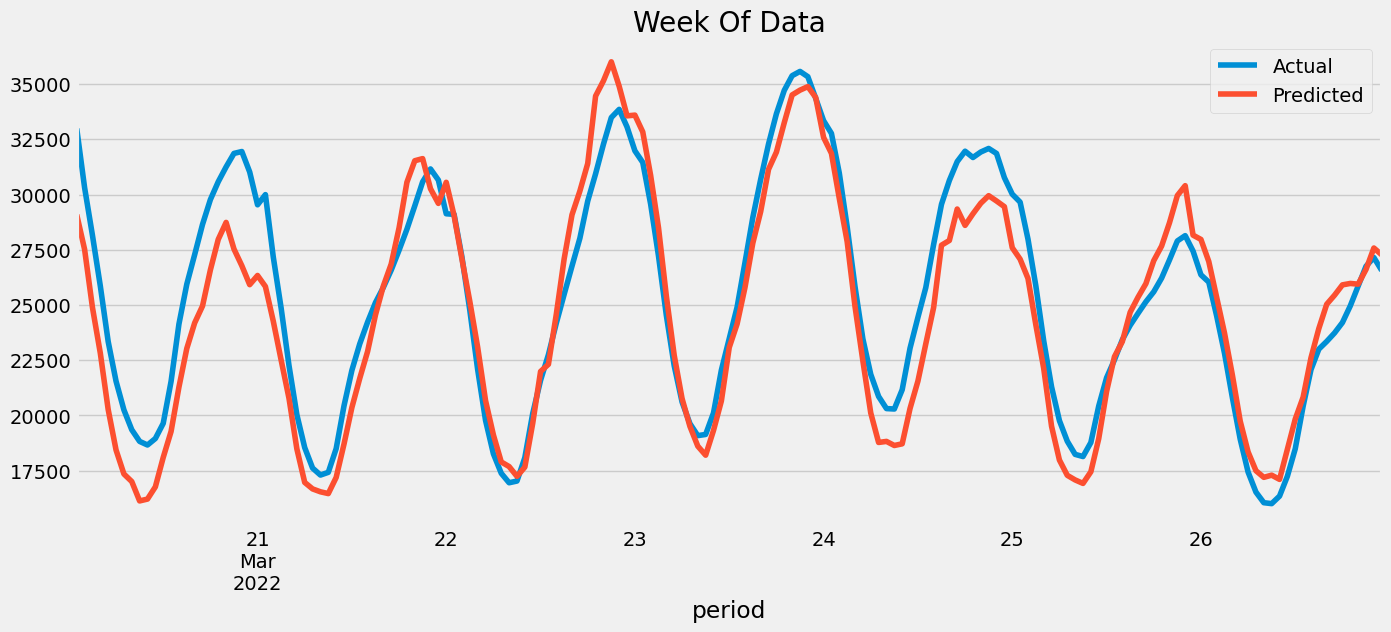

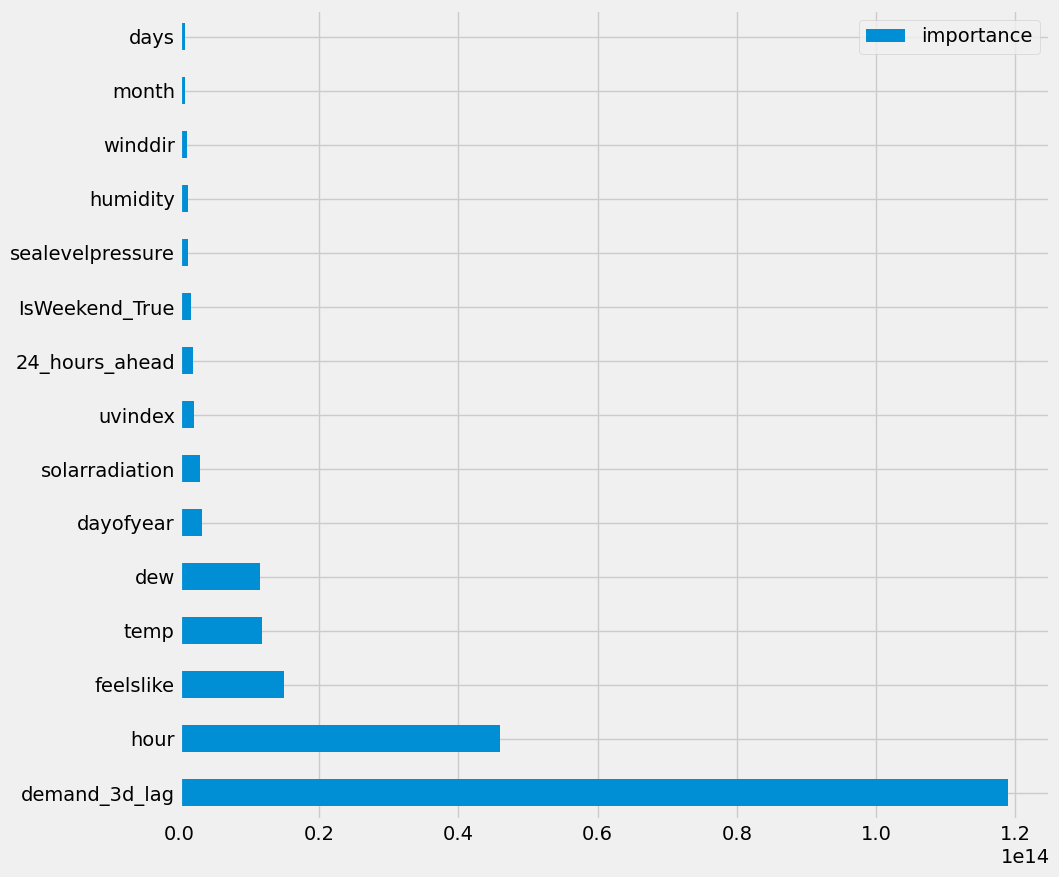

In [79]:
model_FL, FL_df = lgbm_train(FL, TX_params1, show_graph='yes') #1708

## Save model to pickel file

In [80]:
# def create_pickle(model,filname, df, df_name):
#     with open(f'{filname}.pkl' ,'wb') as f:
#         pickle.dump(model,f)
#     df.to_parquet(f'{df_name}.parquet', engine='pyarrow')
#

In [82]:
# dump_tx = create_pickle(model_TX, '../app/Data/TX/model_TX',Texas_df,'../app/Data/TX/texas_df')

In [83]:
# dump_ny = create_pickle(model_NY, '../app/Data/NY//model_NY',NY_df,'../app/Data/NY/NY_df')

In [85]:
# dump_fl = create_pickle(model_FL, '../app/Data/FL/model_FL',FL_df,'../app/Data/FL/FL_df')

In [86]:
# dump_ca = create_pickle(model_CA, '../app/Data/CA/model_CA',CA_df,'../app/Data/CA/CA_df')